<a href="https://colab.research.google.com/github/abasu0713/machine-learning-notebooks/blob/master/optimus%5Bbeta%5D-backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Optimus - BackTesting</h1>
<p>This is an experimental Jupyter Notebook for back-testing a <a href="https://github.com/abasu0713/machine-learning-notebooks/blob/master/optimus%5Bbeta%5D-data.ipynb">trained deep reinforcement learning model</a> and comparing it's performance with real market data. </p>

In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.20
    Uninstalling SQLAlchemy-2.0.20:
      Successfully uninstalled SQLAlchemy-2.0.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.49 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-9jz_go7_
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-9jz_go7_
  Resolved ht

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

%matplotlib inline
from finrl.config import INDICATORS

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
train = pd.read_csv('train-stock-market-data.csv')
trade = pd.read_csv('trade-stock-market-data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure
# it has the columns and index in the form that could be make into the environment.
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [ ]:
trained_a2c = A2C.load("agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("agent_td3") if if_using_td3 else None
trained_sac = SAC.load("agent_sac") if if_using_sac else None

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c,
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [ ]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg,
    environment = e_trade_gym) if if_using_ddpg else (None, None)

hit end!


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo,
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [ ]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3,
    environment = e_trade_gym) if if_using_td3 else (None, None)

hit end!


In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac,
    environment = e_trade_gym) if if_using_sac else (None, None)


hit end!


In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 89.25041199, 230.55337524,  90.43218994, ...,  46.16302872,
         35.11460495, 113.78935242],
       [ 89.25041199, 233.3729248 ,  90.70142365, ...,  46.26436234,
         36.05948257, 113.33300781],
       [ 91.63790131, 231.57458496,  92.86486053, ...,  46.64435196,
         37.07305527, 113.02879333],
       ...,
       [146.9400177 , 194.42749023, 178.08135986, ...,  47.43144608,
         44.49522781, 145.47286987],
       [147.61225891, 195.41072083, 176.75291443, ...,  47.88248825,
         43.67257309, 144.20289612],
       [147.14764404, 193.44424438, 173.90063477, ...,  47.47654343,
         42.59680939, 143.02017212]])

In [ ]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4744.487,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  782.279,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.833,    0.   ,    0.   ,    0.   ,
        474.034,  715.534,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (319, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0]) if if_using_ddpg else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0]) if if_using_td3 else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ddpg: result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')


<ipython-input-26-ea18356be364>:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  if if_using_td3: result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)


In [ ]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('DDPG') if if_using_ddpg else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('TD3') if if_using_td3 else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia')
result.columns = col_name

In [ ]:

result

,A2C,DDPG,PPO,TD3,SAC,Mean Var,djia
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001917e+06,1.000000e+06
2020-07-02,1.000425e+06,1.000525e+06,1.000138e+06,1.000704e+06,1.000503e+06,1.004234e+06,1.021449e+06
2020-07-06,1.003125e+06,1.007096e+06,1.001342e+06,1.006632e+06,1.006874e+06,1.023225e+06,1.021449e+06
2020-07-07,1.000333e+06,9.951071e+05,9.998290e+05,9.969957e+05,9.967966e+05,1.014021e+06,1.006031e+06
2020-07-08,1.002358e+06,9.988141e+05,1.001236e+06,1.001648e+06,1.000536e+06,1.029461e+06,1.012912e+06
...,...,...,...,...,...,...,...
2021-10-22,1.412127e+06,1.386513e+06,1.482176e+06,1.359382e+06,1.370003e+06,1.535668e+06,1.386322e+06
2021-10-25,1.412938e+06,1.389809e+06,1.485777e+06,1.359766e+06,1.367573e+06,1.542078e+06,1.388813e+06
2021-10-26,1.407884e+06,1.388454e+06,1.487443e+06,1.365519e+06,1.371493e+06,1.545514e+06,1.389427e+06


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

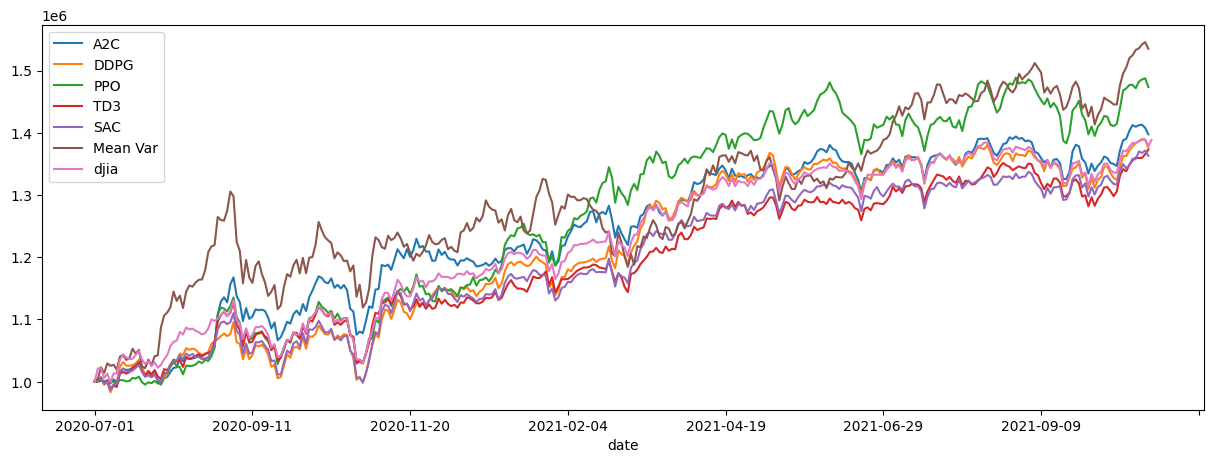

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()